In [13]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy.stats as stats
import yfinance as yf
import pandas_market_calendars as mcal
from pandas_datareader.data import DataReader as dr
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

In [14]:
# yahoo finance ticker symbol
ticker = "SPY"

# option variables

#spot_price = 300
spot_price = yf.download("SPY", period='1d', interval='1d')["Close"].iloc[-1]

strike_price = 250


# time data

#current_date = '2024-01-28'
current_date = datetime.now()
expiration_date = '2024-06-10'
# get trading days
exchange = 'NYSE'  # select exchange
cal = mcal.get_calendar(exchange)
trading_days = mcal.date_range(cal.schedule(start_date=current_date, end_date=expiration_date), frequency='1D')
number_trading_days = len(trading_days) - 1                 #excluding current day from trading days

trading_days_per_year = 252                                 #fair to assume 252
time_in_years = number_trading_days/trading_days_per_year
delta_t = time_in_years / number_trading_days               #leangth of time step

# implied volatility
impl_vol = 0.15


number_trading_days

[*********************100%%**********************]  1 of 1 completed


73

In [15]:
# unrelated (get all S&P price data to excel sheet)

s_p_data = yf.download("^GSPC", period='max', interval='1d')["Adj Close"]

s_p_data.to_frame(name='column_name').to_excel('xlfile.xlsx', sheet_name='s')

[*********************100%%**********************]  1 of 1 completed


In [22]:
# calculate riskfree-rate via the Nelson-Siegel-Svensson method based on U.S. Treasury yields

# get yield curve data 
syms = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
yc = dr(syms, 'fred', start=current_date - timedelta(days=10))
yield_maturities = np.array([1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yeilds = np.array(yc.iloc[-1,:]).astype(float)/100

#NSS model calibrate
curve_fit, status = calibrate_nss_ols(yield_maturities,yeilds) 

# risk-free rate
rf = curve_fit(time_in_years)
rf

0.05403988365186075

In [47]:
start = datetime(2005, 5, 1)
end = datetime(2024, 6, 1)

SOFR_90_day = dr("SOFR90DAYAVG", 'fred',  start=current_date - timedelta(days=10))
SOFR_90_day

,SOFR90DAYAVG
DATE,
2024-02-16,5.35945
2024-02-19,NaN
2024-02-20,5.35873
2024-02-21,5.35863
2024-02-22,5.35851
2024-02-23,5.35831


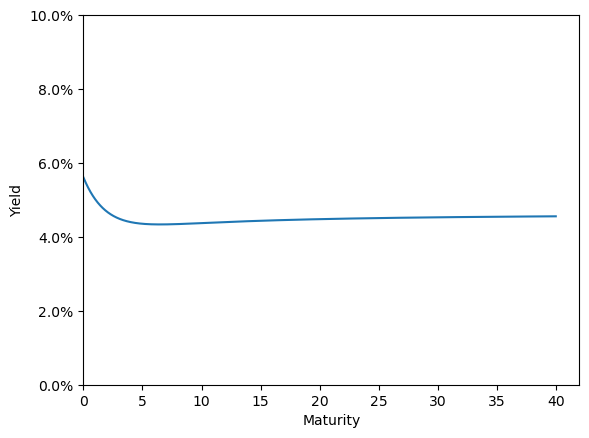

In [17]:
plot_maturities = np.arange(0, 40, 0.01)
plot_yields = curve_fit(plot_maturities)
plt.plot(plot_maturities, plot_yields)
plt.xlabel('Maturity')
plt.ylabel('Yield')
plt.ylim(0, 0.10) 
plt.xlim(0) 
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:,.1%}'.format))
plt.show()
plt.show()

In [18]:
# run monte carlo simmulation

sim_runs = 300000

random_growth_factors = np.exp((rf-0.5*impl_vol**2)*delta_t + impl_vol*(delta_t**0.5)*np.random.normal(0, 1, size=(number_trading_days, sim_runs)))

growth_t0 = np.ones((1, random_growth_factors.shape[1])) * spot_price
growth_paths = np.vstack((growth_t0, random_growth_factors))
cumulative_growth_paths = np.cumprod(growth_paths, axis=0)

#simulated_performance = pd.DataFrame(cumulative_growth_paths)
#simulated_performance


In [19]:
prices_maturity = cumulative_growth_paths[-1]

payoff_long_call = np.maximum((prices_maturity-strike_price),0)
price_long_call = payoff_long_call.mean() * np.exp(-rf*time_in_years)
price_long_call

261.6729397380192

In [20]:
# simulation dataframe with dates

simulation_df = pd.DataFrame(cumulative_growth_paths)
simulation_df.set_index(pd.Index(trading_days), inplace=True)
simulation_df

,0,1,2,3,4,5,6,7,8,9,...,299990,299991,299992,299993,299994,299995,299996,299997,299998,299999
2024-02-26 21:00:00+00:00,507.850006,507.850006,507.850006,507.850006,507.850006,507.850006,507.850006,507.850006,507.850006,507.850006,...,507.850006,507.850006,507.850006,507.850006,507.850006,507.850006,507.850006,507.850006,507.850006,507.850006
2024-02-27 21:00:00+00:00,507.411587,507.034818,503.667282,508.853405,502.043940,507.773051,510.870442,512.416001,510.677892,514.245190,...,509.437589,504.500300,511.805470,506.230013,499.887564,506.191194,508.637096,506.031187,513.072151,507.882270
2024-02-28 21:00:00+00:00,513.396559,513.544435,504.614611,511.091599,494.565864,507.902207,520.843419,518.791159,504.283991,516.581445,...,512.259859,502.304086,512.075046,505.014872,494.480040,509.739498,514.312461,509.742789,518.207789,507.962091
2024-02-29 21:00:00+00:00,517.606848,519.834689,499.181854,510.039319,491.077169,512.813274,526.386831,519.575525,506.330873,511.975137,...,510.178969,505.881110,506.144521,514.558867,485.362102,505.218629,518.189437,506.491857,525.830281,509.356256
2024-03-01 21:00:00+00:00,519.049796,519.930417,493.630808,518.098285,500.534463,515.083130,524.600268,518.018232,506.236531,510.023644,...,505.252557,499.871393,512.997803,505.863633,479.761882,495.355752,520.163466,513.542247,523.572107,502.830928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-04 20:00:00+00:00,463.118425,532.189910,500.621216,564.406887,516.038856,525.820172,504.835296,546.782431,555.227993,519.153783,...,550.752114,544.608793,613.931093,557.075142,519.411889,526.341821,474.806736,483.391463,487.026473,525.069146
2024-06-05 20:00:00+00:00,461.765328,536.296510,500.364037,565.897790,518.416858,521.593122,503.783415,539.863423,549.363929,520.158839,...,555.237998,539.143251,627.658906,548.781221,520.285176,522.932906,475.277038,482.373040,488.426253,524.263626
2024-06-06 20:00:00+00:00,471.292560,528.920963,496.280744,573.249795,525.677617,520.695126,503.832850,534.539437,550.910243,522.144188,...,558.934095,548.226942,617.469092,546.578202,520.060948,521.941690,474.384737,487.768399,491.909824,521.716415
2024-06-07 20:00:00+00:00,475.104080,526.123871,495.458985,571.545971,532.764680,524.034214,502.009116,535.937468,550.574473,531.220743,...,565.482349,548.808539,618.898314,548.312370,522.424006,512.939436,478.483443,482.976528,500.690106,516.849330


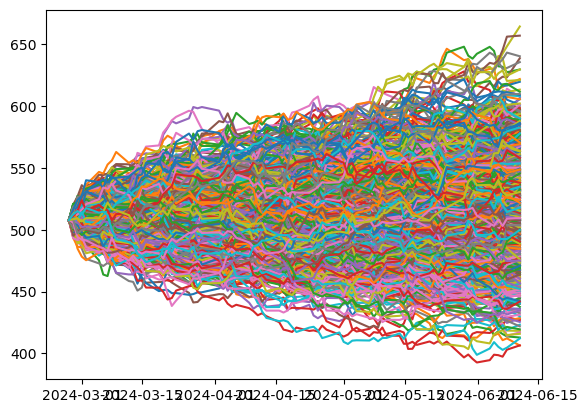

In [21]:
plt.plot(simulation_df.iloc[:, :1000])
plt.show()